In [20]:
import sys, os, shutil
import argparse
from utils import load_img_to_array, save_array_to_img, dilate_mask, \
    show_mask, show_points, get_clicked_point
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import albumentations as A

In [4]:
def draw_bounding_boxes(image, bbox_data):
    for data in bbox_data:
        class_id, x_center, y_center, width, height = data
        x_center, y_center, width, height = [int(float(val) * image.shape[1]) if i % 2 == 0 else int(float(val) * image.shape[0]) for i, val in enumerate([x_center, y_center, width, height])]

        # 좌표 계산
        top_left = (x_center - width // 2, y_center - height // 2)
        bottom_right = (x_center + width // 2, y_center + height // 2)

        # 바운딩 박스 그리기
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
        # 레이블 표시
        cv2.putText(image, str(class_id), (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

In [5]:
def draw_three_images(image1, image2, image3, bbox_data):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
    ax1.imshow(image1)
    ax1.axis('off')

    # 바운딩 박스와 레이블을 그린 이미지
    #draw_bounding_boxes(image2, bbox_data)
    ax2.imshow(image2)
    ax2.axis('off')

    draw_bounding_boxes(image3, bbox_data)
    ax3.imshow(image3)
    ax3.axis('off')
    plt.show()

In [25]:
def apply_transform_to_masked_area(image, mask, transform):
    # 마스크 영역에만 변형을 적용하기 위해 ROI를 추출합니다.
    roi = image.copy()
    roi[mask == 0] = 0  # 마스크가 0인 부분을 제거 (검은색으로 만듦)

    # 변형 적용
    transformed_img = transform(image=roi)['image']
    # 변형된 이미지를 원본 이미지에 다시 합치기
    image[mask != 0] = transformed_img[mask != 0]

    return image

def apply_transform_to_background(image, mask, transform):
    # 배경에만 변형을 적용하기 위해 배경 ROI를 추출합니다.
    background_roi = image.copy()
    background_roi[mask != 0] = 0  # 마스크가 0이 아닌 부분을 제거 (검은색으로 만듦)

    # 변형 적용
    transformed_background = transform(image=background_roi)['image']

    # 변형된 배경을 원본 이미지에 다시 합치기
    # 이 때 객체가 있는 부분은 그대로 유지합니다.
    image[mask == 0] = transformed_background[mask == 0]

    return image

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
        
def copy_image_files(src_folder, dest_folder):
    # 이미지 파일 확장자
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    create_folder_if_not_exists(dest_folder)

    # 원본 폴더에서 파일 목록을 가져와서 이미지 파일만 복사
    for filename in os.listdir(src_folder):
        if os.path.splitext(filename)[1].lower() in image_extensions:
            src_path = os.path.join(src_folder, filename)
            dest_path = os.path.join(dest_folder, filename)
            shutil.copy2(src_path, dest_path)
            print(f'파일 복사됨: {filename}')


In [22]:
img_folder_path =f'../wim_data/final_dataset/train/images/'
mask_folder_path =f'../wim_data/object_processing_masks/'
txt_folder_path = f'../wim_data/train/labels/'

mask_file = '2023-04-24_41.mp4#t=126_mask.jpg'

### parameters

In [27]:
brightness_from, brightness_to =0.5, 1
contrast_from, contrast_to = 0, 0

transform = A.Compose([
    A.RandomBrightnessContrast(
        always_apply=True, p=1.0,
        brightness_limit=(brightness_from,brightness_to),
        contrast_limit=(contrast_from, contrast_to),
        brightness_by_max=False),
])
# Declare an augmentation pipeline

In [12]:
splited = os.path.splitext(mask_file)
image_file = splited[0][:-5] + splited[1]

print(img_folder_path+image_file)
img2 = load_img_to_array(img_folder_path+image_file)
img = load_img_to_array(img_folder_path+image_file)
mask = load_img_to_array(mask_folder_path + mask_file)


txt_file = os.path.join(txt_folder_path, os.path.splitext(image_file)[0] + '.txt')

with open(txt_file, 'r') as file:
    lines = file.readlines()
    bbox_data = [line.strip().split() for line in lines]

# 기호에 맞게 ㅎ
#transformed_img = apply_transform_to_background(img2, mask, transform)
transformed_img = apply_transform_to_masked_area(img2, mask, transform)

../wim_data/final_dataset/train/images/2023-04-24_41.mp4#t=126.jpg


NameError: name 'apply_transform_to_masked_area' is not defined

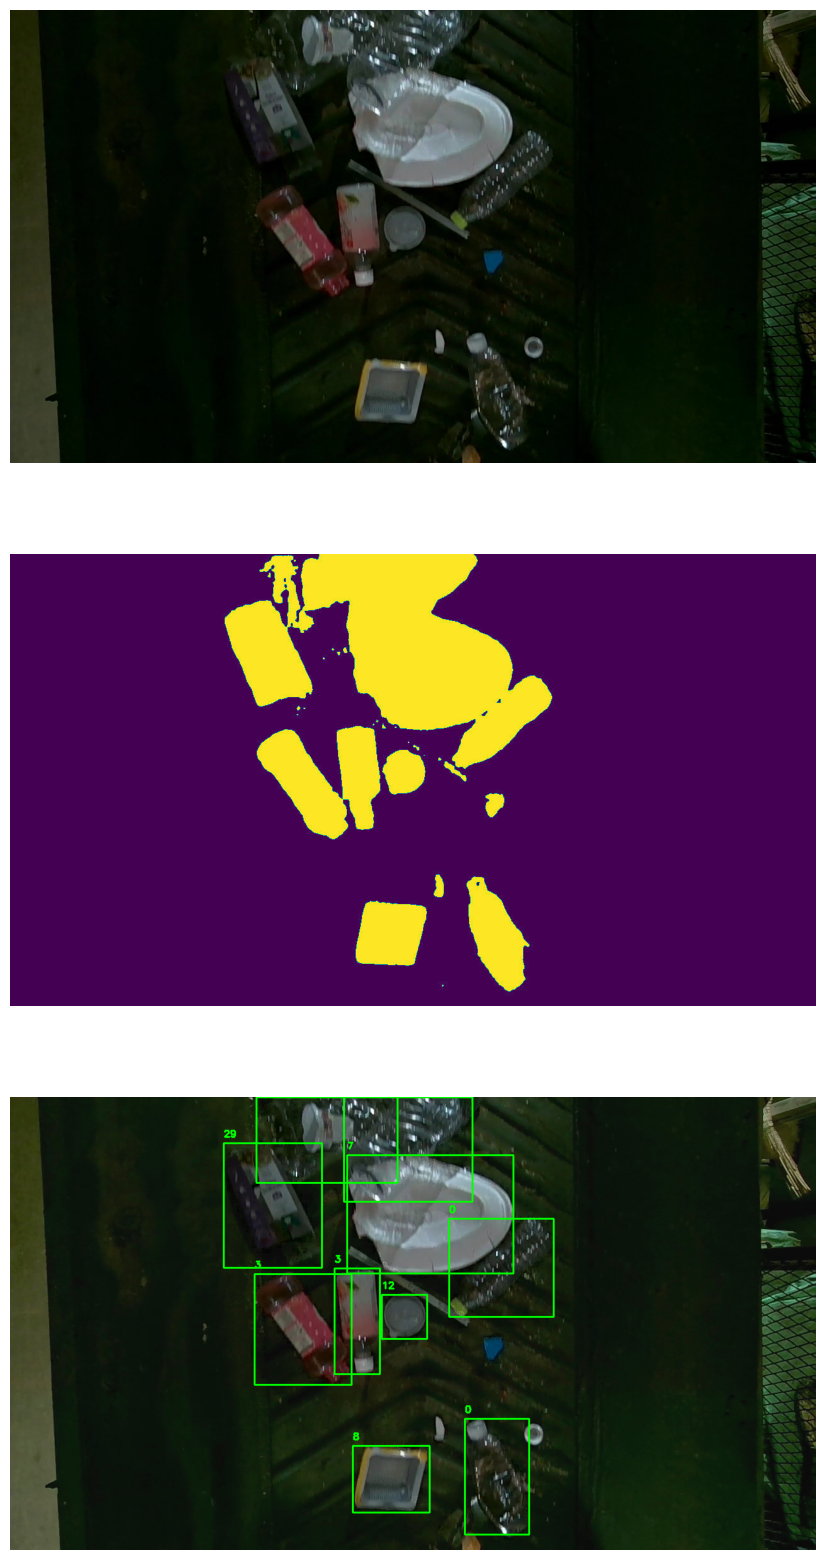

In [17]:
draw_three_images(img,mask, img2, bbox_data)

#### 자동화

In [30]:
mask_folder_path =f'../wim_data/object_processing_masks/'
img_folder_path =f'../wim_data/final_dataset/train/images/'

In [31]:
mask_files = [f for f in os.listdir(mask_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print(len(mask_files))

1200


In [32]:
par_name = f'b_{brightness_from}-{brightness_to}_c_{contrast_from}-{contrast_to}'
processed_image_path = f'../wim_data/processed_images/{par_name}/'
val_path = '/raid/coss07/yolov8/yolov8/final_dataset/val'
test_path = '/raid/coss07/yolov8/yolov8/final_dataset/test'

In [33]:

for mask_file in tqdm(mask_files):
    splited = os.path.splitext(mask_file)
    image_file = splited[0][:-5] + splited[1]
    img = load_img_to_array(img_folder_path+image_file)
    mask = load_img_to_array(mask_folder_path + mask_file)
    
    transformed_img = apply_transform_to_masked_area(img, mask, transform)
    
    create_folder_if_not_exists(processed_image_path+'train')
    
    save_array_to_img(transformed_img, processed_image_path + image_file)
    copy_image_files(val_path, processed_image_path+'val')
    copy_image_files(test_path, processed_image_path+'test')

  0%|          | 1/1200 [00:00<02:05,  9.54it/s]

폴더 생성됨: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더 생성됨: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더 생성됨: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  0%|          | 2/1200 [00:00<03:01,  6.60it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  0%|          | 5/1200 [00:00<02:45,  7.20it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  0%|          | 6/1200 [00:00<02:31,  7.87it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  1%|          | 9/1200 [00:01<02:20,  8.48it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  1%|          | 10/1200 [00:01<02:44,  7.22it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  1%|          | 13/1200 [00:01<02:35,  7.62it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  1%|          | 14/1200 [00:01<02:48,  7.02it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  1%|▏         | 16/1200 [00:02<02:45,  7.17it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  2%|▏         | 18/1200 [00:02<03:08,  6.26it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  2%|▏         | 19/1200 [00:02<03:25,  5.76it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  2%|▏         | 20/1200 [00:02<03:24,  5.78it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  2%|▏         | 22/1200 [00:03<03:06,  6.31it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  2%|▏         | 24/1200 [00:03<03:03,  6.41it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  2%|▏         | 27/1200 [00:03<02:43,  7.19it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  2%|▏         | 29/1200 [00:04<02:27,  7.96it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  3%|▎         | 31/1200 [00:04<02:09,  9.04it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  3%|▎         | 32/1200 [00:04<02:28,  7.86it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  3%|▎         | 34/1200 [00:04<02:52,  6.76it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  3%|▎         | 35/1200 [00:04<02:59,  6.51it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  3%|▎         | 36/1200 [00:05<03:20,  5.80it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  3%|▎         | 38/1200 [00:05<03:01,  6.41it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  3%|▎         | 41/1200 [00:05<02:40,  7.21it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  4%|▎         | 42/1200 [00:05<02:49,  6.85it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  4%|▍         | 45/1200 [00:06<02:26,  7.87it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  4%|▍         | 47/1200 [00:06<02:34,  7.45it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  4%|▍         | 49/1200 [00:06<02:34,  7.45it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  4%|▍         | 51/1200 [00:07<02:56,  6.50it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  4%|▍         | 53/1200 [00:07<02:49,  6.75it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  5%|▍         | 55/1200 [00:07<02:46,  6.88it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  5%|▍         | 57/1200 [00:08<02:40,  7.12it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  5%|▌         | 60/1200 [00:08<02:30,  7.57it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  5%|▌         | 61/1200 [00:08<02:45,  6.89it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  5%|▌         | 63/1200 [00:08<02:37,  7.23it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  5%|▌         | 65/1200 [00:09<02:13,  8.47it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  6%|▌         | 67/1200 [00:09<02:46,  6.79it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  6%|▌         | 68/1200 [00:09<02:59,  6.31it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  6%|▌         | 71/1200 [00:09<02:23,  7.85it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  6%|▌         | 73/1200 [00:10<02:07,  8.81it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  6%|▋         | 75/1200 [00:10<01:53,  9.89it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  6%|▋         | 77/1200 [00:10<02:27,  7.63it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  7%|▋         | 80/1200 [00:11<02:16,  8.22it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  7%|▋         | 82/1200 [00:11<02:02,  9.10it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  7%|▋         | 85/1200 [00:11<01:51, 10.04it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  7%|▋         | 87/1200 [00:11<01:44, 10.61it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  7%|▋         | 89/1200 [00:11<02:01,  9.14it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  8%|▊         | 90/1200 [00:12<02:15,  8.20it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  8%|▊         | 92/1200 [00:12<02:23,  7.73it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  8%|▊         | 94/1200 [00:12<02:29,  7.42it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  8%|▊         | 95/1200 [00:12<02:44,  6.74it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  8%|▊         | 96/1200 [00:13<03:04,  5.99it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  8%|▊         | 97/1200 [00:13<03:14,  5.67it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


  8%|▊         | 99/1200 [00:13<02:52,  6.40it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train


  8%|▊         | 102/1200 [00:13<02:36,  7.01it/s]

폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/train
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/val
폴더가 이미 존재함: ../wim_data/processed_images/b_0.5-1_c_0-0/test


In [76]:
processed_img = [f for f in os.listdir(processed_image_path) if f.endswith('.jpg') or f.endswith('.png')]
print(len(processed_img))

800
